## Colton Lapp
#### HW1 - GameStop Stock Predictions

In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummaryX import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os
import time
import datetime

# 0. Get Data

## Download Stock Data for all NYSE 

- Get list of tickers
- Use YFinance to pull data for relevant period

In [212]:
# URL of the CSV file containing the list of stock tickers
# from: https://datahub.io/core/nyse-other-listings 

url = 'https://pkgstore.datahub.io/core/nyse-other-listings/nyse-listed_csv/data/3c88fab8ec158c3cd55145243fe5fcdf/nyse-listed_csv.csv'

# Read the CSV file into a DataFrame
stock_tickers_df = pd.read_csv(url)

stock_tickers_df.head()

,ACT Symbol,Company Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Inc. Common Stock
2,AA$B,Alcoa Inc. Depository Shares Representing 1/10...
3,AAC,"AAC Holdings, Inc. Common Stock"
4,AAN,"Aaron's, Inc. Common Stock"


In [213]:
# Check if stock_data.csv exists and make boolean variable

file_exists = os.path.isfile('data/stock_data.csv')
if file_exists:
    print('stock_data.csv exists')

stock_data.csv exists


In [214]:
# Download gamestop stock data using yfinance
import yfinance as yf
import pandas as pd

if not file_exists:

    # Get the list of top 1000 companies or your desired list of symbols
    # Here, we are using a sample list of symbols for demonstration purposes.
    # You may want to replace it with the actual symbols you are interested in.
    symbols = stock_tickers_df['ACT Symbol'].tolist()

    # Define the date range
    start_date = "2020-01-01"
    end_date = "2021-12-30"

    # Create an empty DataFrame to store the data
    df = pd.DataFrame()

    # Loop through each symbol and fetch the data
    for symbol in symbols:
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        
        # Extract only the "Close" and "Volume" columns
        stock_data = stock_data[["Close", "Volume"]]
        
        # Rename columns with the symbol for clarity
        stock_data.columns = [f"{symbol}_Close", f"{symbol}_Volume"]
        
        # Merge the data into the main DataFrame
        df = pd.concat([df, stock_data], axis=1)

    # Print the resulting DataFrame
    print(df.head())




In [215]:
# Drop any column that has nan values
if not file_exists:
    df = df.dropna(axis=1)

    print(f"Shape: {df.shape}")

    # Get max and min time
    max_time = df.index.max()
    min_time = df.index.min()
    print(f"Max time: {max_time}, Min time: {min_time}")



In [216]:
# Save the data to a CSV file
if not file_exists:
    df.to_csv("data/stock_data.csv")

In [217]:
# Load stock data
df = pd.read_csv("data/stock_data.csv", index_col=0, parse_dates=True)

# Create df of stock data in terms of pct change
df_pct_change = df.pct_change()
df_pct_change.head()

# Save pct change df
df_pct_change.to_csv("data/stock_data_pct_change.csv")


# 1. Model Building
## Time Series Forecasting

### Read in stock data 


In [218]:

# Read in percent change data
data_pct_change = pd.read_csv('data/stock_data_pct_change.csv')

# Read in levels data
data = pd.read_csv('data/stock_data.csv')

# drop rows where all values are nan besides date
data_pct_change = data_pct_change.dropna(how='all', subset=data_pct_change.columns[1:])
data = data.dropna(how='all', subset=data.columns[1:])


# Set start date and end date
start_date = '2020-06-01'
end_date = '2021-08-31'

# Subset data to only include dates between start and end date
data_pct_change = data_pct_change[(data_pct_change['Date'] >= start_date) & (data_pct_change['Date'] <= end_date)]
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]


print(f"Shape of data: {data_pct_change.shape}")
data_pct_change.head()

Shape of data: (317, 3157)


Date   A_Close  A_Volume  AA_Close  AA_Volume  AAP_Close  \
103  2020-06-01  0.020082  0.034705  0.030402  -0.303473   0.003373   
104  2020-06-02  0.004226 -0.320794  0.045311   0.134276  -0.002146   
105  2020-06-03  0.002215 -0.178453  0.085686   0.367251   0.020288   
106  2020-06-04  0.007183  0.611212  0.080780   0.333995  -0.000843   
107  2020-06-05 -0.008339  0.277082  0.036942   0.634000   0.027426   

     AAP_Volume  AAT_Close  AAT_Volume  AB_Close  AB_Volume  ABBV_Close  \
103   -0.364948   0.016049   -0.445626  0.023228  -0.321540   -0.021258   
104   -0.357551   0.014667    0.376844  0.017613  -0.081533    0.003749   
105   -0.038867   0.090437    0.825121  0.012692   0.463300   -0.001648   
106   -0.040246   0.057444   -0.204696 -0.001899  -0.360772    0.023655   
107    0.864567   0.055288   -0.148708  0.000761   0.981221    0.008706   

     ABBV_Volume  ABEV_Close  ABEV_Volume  ABG_Close  ABG_Volume  ABM_Close  \
103    -0.383195    0.025974    -0.152131   0.006503   -0.255450   0.048812   
104     0.109209    0.059072    -0.139445   0.020619   -0.017187  -0.002172   
105    -0.087631    0.059761    -0.160881   0.062492    0.769430   0.036692   
106     0.109136   -0.007519    -0.206680   0.022310   -0.327233   0.031794   
107     0.010960    0.068182     0.740787   0.010539    0.801959   0.062209   

     ABM_Volume  ABR_Close  ABR_Volume  ABT_Close  ABT_Volume  ACCO_Close  \
103    0.591029   0.023753   -0.318570  -0.020122   -0.462287    0.000000   
104   -0.585459   0.015081    0.117405  -0.004193    0.172885    0.040388   
105    0.474589   0.056000    1.056422  -0.013172    0.259958    0.069876   
106   -0.224362   0.009740   -0.072544  -0.034464    0.131239   -0.002903   
107    0.192986   0.042872   -0.155468   0.018244    0.302943    0.043668   

     ACCO_Volume  ACM_Close  ACM_Volume  ACN_Close  ACN_Volume  ACP_Close  \
103     0.078844   0.011349   -0.477795   0.008729   -0.396229   0.029233   
104    -0.307291   0.108901    2.840479   0.011801    0.266789   0.016568   
105     0.066064   0.010810   -0.157510   0.007289   -0.172133   0.010477   
106     0.106503   0.004551   -0.510651  -0.020166    0.526971  -0.003456   
107     0.699957   0.029219    0.137958   0.026539    0.035286   0.017341   

     ACP_Volume  ACRE_Close  ACRE_Volume  ADC_Close  ADC_Volume  ADM_Close  \
103   -0.072135    0.076510     0.419701   0.026286   -0.536793  -0.010684   
104   -0.364058    0.057356    -0.152942   0.006675   -0.220736   0.020057   
105    0.661781    0.080189     0.107564   0.037780    1.284181   0.021175   
106   -0.288104    0.057860    -0.085487   0.001783   -0.423702   0.015552   
107    0.260519    0.046440     0.092283   0.017651    0.256637   0.033544   

     ADM_Volume  ADPT_Close  ADPT_Volume  ADT_Close  ADT_Volume  ADX_Close  \
103   -0.317562    0.009561    -0.409255   0.122881    1.077250   0.005427   
104    0.132340   -0.006399    -0.543266   0.022642    0.088888   0.004723   
105   -0.214244    0.021638     2.358897  -0.023370   -0.503372   0.016118   
106    0.080246   -0.011599    -0.498369   0.022670    0.038888  -0.005288   
107    0.436858   -0.011990     0.963229   0.030788    0.234907   0.020598   

     ADX_Volume  AEE_Close  AEE_Volume  AEG_Close  AEG_Volume  AEL_Close  \
103    0.254728  -0.004817   -0.447043   0.063670   -0.440569  -0.017059   
104   -0.311352   0.007261    0.313903   0.024648   -0.147456  -0.005160   
105    0.667579   0.015619   -0.014153   0.106529    0.594726   0.059406   
106   -0.706317  -0.027471   -0.057498   0.006211   -0.042461   0.021362   
107    2.544693   0.021489    0.360193   0.046296    0.195909   0.086710   

     AEL_Volume  AEM_Close  AEM_Volume  AEO_Close  AEO_Volume  AEP_Close  \
103   -0.160258   0.001719   -0.238156   0.079694    0.767666   0.010440   
104   -0.295488  -0.030105   -0.080327   0.040445    0.571545  -0.001857   
105   -0.100363  -0.063364    1.151248   0.146744    0.085010   0.011747   
106    0.046324   0.000172   -0.4

### Correlation Analysis:
#### Identify which stocks from the NYSE correlate with Gamestop to include in our model


Convert stock levels to percent change to see which stocks move up/down with gamestop

In [219]:
# Create column "GME_close_day_ahead" which is the close price of GME one day ahead
data_pct_change['GME_close_day_ahead'] = data_pct_change['GME_Close'].shift(-1)

# Move columns 'GME_close_day_ahead', 'GME_Close' and 'GME_Volume' to the front of the dataframe
cols = list(data_pct_change.columns) ; cols.remove('GME_close_day_ahead');cols.remove('GME_Close');cols.remove('GME_Volume'); cols.remove('Date')
cols = ['Date', 'GME_close_day_ahead', 'GME_Close', 'GME_Volume'] + cols
data_pct_change = data_pct_change[cols]

data_pct_change.head()

Date  GME_close_day_ahead  GME_Close  GME_Volume   A_Close  \
103  2020-06-01             0.012106   0.017241   -0.340788  0.020082   
104  2020-06-02             0.062201   0.012106   -0.092740  0.004226   
105  2020-06-03             0.006757   0.062201    0.281928  0.002215   
106  2020-06-04            -0.073825   0.006757    0.157009  0.007183   
107  2020-06-05             0.210145  -0.073825    0.785391 -0.008339   

     A_Volume  AA_Close  AA_Volume  AAP_Close  AAP_Volume  AAT_Close  \
103  0.034705  0.030402  -0.303473   0.003373   -0.364948   0.016049   
104 -0.320794  0.045311   0.134276  -0.002146   -0.357551   0.014667   
105 -0.178453  0.085686   0.367251   0.020288   -0.038867   0.090437   
106  0.611212  0.080780   0.333995  -0.000843   -0.040246   0.057444   
107  0.277082  0.036942   0.634000   0.027426    0.864567   0.055288   

     AAT_Volume  AB_Close  AB_Volume  ABBV_Close  ABBV_Volume  ABEV_Close  \
103   -0.445626  0.023228  -0.321540   -0.021258    -0.383195    0.025974   
104    0.376844  0.017613  -0.081533    0.003749     0.109209    0.059072   
105    0.825121  0.012692   0.463300   -0.001648    -0.087631    0.059761   
106   -0.204696 -0.001899  -0.360772    0.023655     0.109136   -0.007519   
107   -0.148708  0.000761   0.981221    0.008706     0.010960    0.068182   

     ABEV_Volume  ABG_Close  ABG_Volume  ABM_Close  ABM_Volume  ABR_Close  \
103    -0.152131   0.006503   -0.255450   0.048812    0.591029   0.023753   
104    -0.139445   0.020619   -0.017187  -0.002172   -0.585459   0.015081   
105    -0.160881   0.062492    0.769430   0.036692    0.474589   0.056000   
106    -0.206680   0.022310   -0.327233   0.031794   -0.224362   0.009740   
107     0.740787   0.010539    0.801959   0.062209    0.192986   0.042872   

     ABR_Volume  ABT_Close  ABT_Volume  ACCO_Close  ACCO_Volume  ACM_Close  \
103   -0.318570  -0.020122   -0.462287    0.000000     0.078844   0.011349   
104    0.117405  -0.004193    0.172885    0.040388    -0.307291   0.108901   
105    1.056422  -0.013172    0.259958    0.069876     0.066064   0.010810   
106   -0.072544  -0.034464    0.131239   -0.002903     0.106503   0.004551   
107   -0.155468   0.018244    0.302943    0.043668     0.699957   0.029219   

     ACM_Volume  ACN_Close  ACN_Volume  ACP_Close  ACP_Volume  ACRE_Close  \
103   -0.477795   0.008729   -0.396229   0.029233   -0.072135    0.076510   
104    2.840479   0.011801    0.266789   0.016568   -0.364058    0.057356   
105   -0.157510   0.007289   -0.172133   0.010477    0.661781    0.080189   
106   -0.510651  -0.020166    0.526971  -0.003456   -0.288104    0.057860   
107    0.137958   0.026539    0.035286   0.017341    0.260519    0.046440   

     ACRE_Volume  ADC_Close  ADC_Volume  ADM_Close  ADM_Volume  ADPT_Close  \
103     0.419701   0.026286   -0.536793  -0.010684   -0.317562    0.009561   
104    -0.152942   0.006675   -0.220736   0.020057    0.132340   -0.006399   
105     0.107564   0.037780    1.284181   0.021175   -0.214244    0.021638   
106    -0.085487   0.001783   -0.423702   0.015552    0.080246   -0.011599   
107     0.092283   0.017651    0.256637   0.033544    0.436858   -0.011990   

     ADPT_Volume  ADT_Close  ADT_Volume  ADX_Close  ADX_Volume  AEE_Close  \
103    -0.409255   0.122881    1.077250   0.005427    0.254728  -0.004817   
104    -0.543266   0.022642    0.088888   0.004723   -0.311352   0.007261   
105     2.358897  -0.023370   -0.503372   0.016118    0.667579   0.015619   
106    -0.498369   0.022670    0.038888  -0.005288   -0.706317  -0.027471   
107     0.963229   0.030788    0.234907   0.020598    2.544693   0.021489   

     AEE_Volume  AEG_Close  AEG_Volume  AEL_Close  AEL_Volume  AEM_Close  \
103   -0.447043   0.063670   -0.440569  -0.017059   -0.160258   0.001719   
104    0.313903   0.024648   -0.147456  -0.005160   -0.295488  -0.030105   
105   -0.014153   0.106529    0.594726   0.059406   -0.100363  -0.063364   
106   -0.057498   0.006211   -0.042461   0.02

#### Calculate correlations

In [220]:
# Find 10 columns that correlate most with GME_close_day_ahead
correlation = data_pct_change.drop('Date', axis=1).corr()

# Subset just 'GME_close_day_ahead' column
correlation = correlation['GME_close_day_ahead']

# Turn correlation into df, making index a column also
correlation = correlation.reset_index()

# Rename index to 'column', and 'GME_close_day_ahead' to 'correlation'
correlation = correlation.rename(columns={'index':'column', 'GME_close_day_ahead':'correlation'})

# Create absolute value of correlation as new column
correlation['abs_correlation'] = abs(correlation['correlation'])

# Sort by absolute value of correlation
correlation = correlation.sort_values(by='abs_correlation', ascending=False)

# Extract ticker from column, text before first underscore
correlation['ticker'] = correlation['column'].apply(lambda x: x.split('_')[0])


correlation.head(30)

,column,correlation,abs_correlation,ticker
0,GME_close_day_ahead,1.000000,1.000000,GME
2220,PBH_Volume,0.367330,0.367330,PBH
2806,TMST_Volume,0.349920,0.349920,TMST
2221,PBI_Close,0.317374,0.317374,PBI
2222,PBI_Volume,0.245946,0.245946,PBI
1820,MITT_Volume,0.242633,0.242633,MITT
348,BGS_Volume,0.207390,0.207390,BGS
2388,PYS_Volume,0.207245,0.207245,PYS
1915,MTR_Close,0.198473,0.198473,MTR
1234,GJT_Volume,-0.195923,0.195923,GJT


#### Merge company names for correlation analysis

In [221]:
url = 'https://pkgstore.datahub.io/core/nyse-other-listings/nyse-listed_csv/data/3c88fab8ec158c3cd55145243fe5fcdf/nyse-listed_csv.csv'
stock_tickers_df = pd.read_csv(url)

# rename 'ACT Symbol' to 'ticker'
stock_tickers_df = stock_tickers_df.rename(columns={'ACT Symbol':'ticker'})

# Merge correlation dataframe with stock_tickers_df to get company names
correlation = correlation.merge(stock_tickers_df, on='ticker', how='left')
correlation.head(30)


,column,correlation,abs_correlation,ticker,Company Name
0,GME_close_day_ahead,1.000000,1.000000,GME,Gamestop Corporation Common Stock
1,PBH_Volume,0.367330,0.367330,PBH,"Prestige Brand Holdings, Inc. Common Stock"
2,TMST_Volume,0.349920,0.349920,TMST,Timken Steel Corporation Common Shares
3,PBI_Close,0.317374,0.317374,PBI,Pitney Bowes Inc. Common Stock
4,PBI_Volume,0.245946,0.245946,PBI,Pitney Bowes Inc. Common Stock
5,MITT_Volume,0.242633,0.242633,MITT,"AG Mortgage Investment Trust, Inc. Common Stock"
6,BGS_Volume,0.207390,0.207390,BGS,"B&G Foods, Inc. B&G Foods, Inc. Common Stock"
7,PYS_Volume,0.207245,0.207245,PYS,Merrill Lynch Depositor Inc PPlus Tr Ser RRD
8,MTR_Close,0.198473,0.198473,MTR,Mesa Royalty Trust Common Stock
9,GJT_Volume,-0.195923,0.195923,GJT,Synthetic Fixed


#### Attach 20 most highly correlated stocks to input data

In [222]:
# Subset the levels data to only include the top 20 correlated columns, with GME_close at front
num_columns = 20
top_20_columns = correlation['column'].head(num_columns).tolist()
top_20_columns.remove('GME_close_day_ahead')
top_20_columns = ['Date', 'GME_Close', 'GME_Volume'] + top_20_columns 
data_subset = data[top_20_columns]

#Print column names
print(f"Columns in data: {data_subset.columns}")

print(f"Shape of data: {data_subset.shape}")
data_subset.head()


Columns in data: Index(['Date', 'GME_Close', 'GME_Volume', 'PBH_Volume', 'TMST_Volume',
       'PBI_Close', 'PBI_Volume', 'MITT_Volume', 'BGS_Volume', 'PYS_Volume',
       'MTR_Close', 'GJT_Volume', 'MBI_Close', 'TRI_Close', 'GJS_Volume',
       'LEE_Volume', 'WLKP_Volume', 'HPP_Volume', 'NOK_Close', 'POST_Close',
       'BTA_Close', 'TMST_Close'],
      dtype='object')
Shape of data: (316, 22)


,Date,GME_Close,GME_Volume,PBH_Volume,TMST_Volume,PBI_Close,PBI_Volume,MITT_Volume,BGS_Volume,PYS_Volume,MTR_Close,GJT_Volume,MBI_Close,TRI_Close,GJS_Volume,LEE_Volume,WLKP_Volume,HPP_Volume,NOK_Close,POST_Close,BTA_Close,TMST_Close
103,2020-06-01 00:00:00,1.0325,10446400,523900,330000,2.58,2160500,968867,1082700,726,6.30,1100,7.05,68.269997,1200,14150,80600,2692600,4.20,57.846859,11.43,3.68
104,2020-06-02 00:00:00,1.0450,9477600,532400,294600,2.47,3323300,787067,699900,1116,6.09,700,7.22,70.260002,1300,27180,76500,3160200,4.31,57.807590,11.49,3.81
105,2020-06-03 00:00:00,1.1100,12149600,437700,299800,2.61,5090800,1028233,2087600,1297,6.05,8600,7.44,70.839996,2300,21180,97200,5953400,4.37,58.854713,11.50,3.96
106,2020-06-04 00:00:00,1.1175,14057200,339100,456800,2.69,2665400,1993267,1936000,734,6.64,500,7.49,69.809998,700,44340,36900,4276000,4.28,57.787956,11.54,4.43
107,2020-06-05 00:00:00,1.0350,25097600,493700,667800,2.90,2434300,4457633,1701200,2372,6.38,1400,7.51,70.949997,0,83130,37100,2685500,4.46,59.528797,11.51,4.10


### Conclusion: Most stocks don't correlate much with Gamestop (around .3 coefficient max)
#### We will include the top 20 stock correlates in our LSTM forecasting model

---
# LSTM Data Engineering 

## Rescale our stock data for better LSTM performance

#### Plot a couple example stocks to see transformation

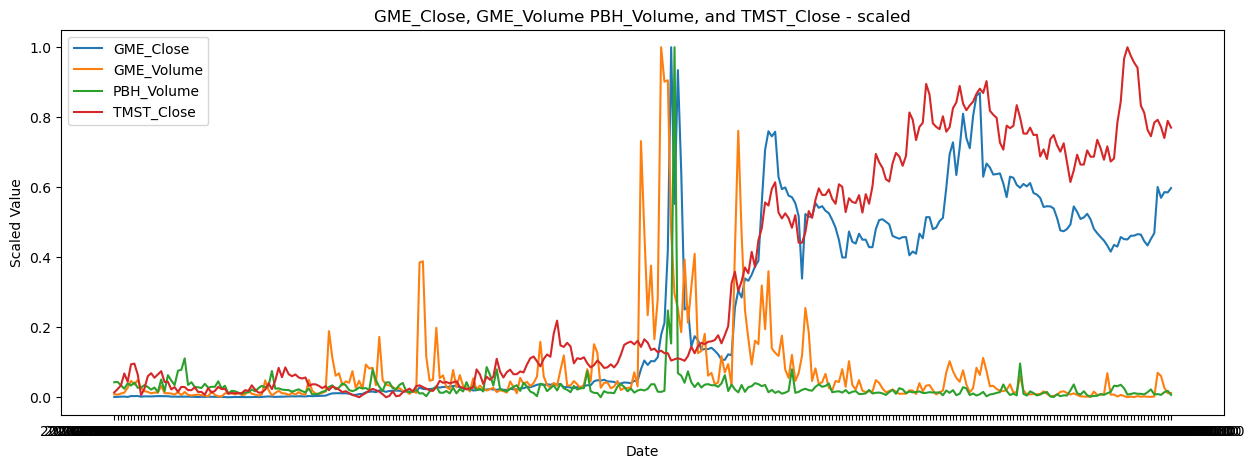

In [223]:
data_transformed = data_subset.copy()
data_transformed = data_transformed.set_index('Date')

scalars = {}
for column in data_transformed.columns:
    scalar = MinMaxScaler()
    data_transformed[column] = scalar.fit_transform(data_transformed[column].values.reshape(-1,1))
    scalars[column] = scalar

data_transformed = data_transformed.reset_index()

# Plot transformed GME_Close, GME_Volume and AMC_Close
plt.figure(figsize=(15, 5))
plt.plot(data_transformed['Date'], data_transformed['GME_Close'], label='GME_Close')
plt.plot(data_transformed['Date'], data_transformed['GME_Volume'], label='GME_Volume')
plt.plot(data_transformed['Date'], data_transformed['PBH_Volume'], label='PBH_Volume')
plt.plot(data_transformed['Date'], data_transformed['TMST_Close'], label='TMST_Close')
plt.title('GME_Close, GME_Volume PBH_Volume, and TMST_Close - scaled')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()


## Create sequence data for LSTM

First, identify indices for test dats period

In [224]:
dates_test = ['2021-06-01',  '2021-08-31']

# Get rows indices where date is between dates in dates_test
test_indices = data_transformed[(data_transformed['Date'] >= dates_test[0]) & (data_transformed['Date'] <= dates_test[1])].index

# Count number of rows in test data by index
n_test_obs = len(test_indices)
print(f"Number of rows in test data: {n_test_obs}")


Number of rows in test data: 64


In [225]:
data_transf_vals = data_transformed.drop('Date', axis=1).values

### Convert DF to sequences of lags for LSTM

In [226]:
# Create input sequences and labels
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length:i+seq_length+1, 0]
        sequences.append((seq, label))
    return sequences

# Define sequence length
seq_length = 3  # Consider this many previous time steps for prediction

# Create sequences
sequences = create_sequences(data_transf_vals, seq_length)

# Convert to PyTorch tensors
inputs = torch.Tensor([seq for seq, _ in sequences])
labels = torch.Tensor([label for _, label in sequences]).unsqueeze(1)  # Unsqueeze to add a singleton dimension

print(f"Shape of inputs: {inputs.shape}")
print(f"Shape of labels: {labels.shape}")


Shape of inputs: torch.Size([313, 3, 21])
Shape of labels: torch.Size([313, 1, 1])


## Train/Val/Test split

In [227]:
# Split into Train, Validation, and Test sets based on num of test obs
nseq = len(sequences)
test_start_index = nseq - n_test_obs

train_val_ratio = 0.8

test_indices = list(range(test_start_index, nseq ))

remaining_obs = list(range(test_start_index))
n_train = int(train_val_ratio * len(remaining_obs))
train_indices = remaining_obs[:n_train]
val_indices = remaining_obs[n_train:]

print(f"Start/End train indices: {train_indices[0]}/{train_indices[-1]}")
print(f"Start/End val indices: {val_indices[0]}/{val_indices[-1]}")
print(f"Start/End test indices: {test_indices[0]}/{test_indices[-1]}")
print(f"Out of a total of {nseq} sequences")


Start/End train indices: 0/198
Start/End val indices: 199/248
Start/End test indices: 249/312
Out of a total of 313 sequences


## Create Tensor datasets/DataLoaders

In [228]:
# the correct shape (batch_size, sequence_length, input_size)

# Create dataset for each set 
train_dataset = TensorDataset(inputs[train_indices], labels[train_indices])
val_dataset = TensorDataset(inputs[val_indices], labels[val_indices])
test_dataset = TensorDataset(inputs[test_indices], labels[test_indices])
entire_dataset = TensorDataset(inputs, labels)

# Create DataLoader for each set, setting pin=True and num_workers = 2
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
entire_loader = DataLoader(entire_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)


#### Check that dataloader is working

In [229]:
# the correct shape (batch_size, sequence_length, input_size)

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    data, label = data
    print(data.shape, label.shape)
    break

torch.Size([4, 3, 21]) torch.Size([4, 1, 1])


## Define Pytorch Training Functions 

In [230]:
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device):

    model.train()
    tloss = 0.0  # Monitoring loss
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (sequences, labels) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()
        ### Move Data to Device (Ideally GPU)
        sequences = sequences.to(device)
        labels = labels.to(device)
        ### Forward Propagation
        outputs = model(sequences)
        ### Loss Calculation
        loss = criterion(outputs, labels)
        ### Backward Propagation
        loss.backward()
        ### Gradient Descent
        optimizer.step()
        tloss += loss.item()
        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))) )
        batch_bar.update()

        ### Release memory
        del sequences, labels, outputs
        torch.cuda.empty_cache()

    batch_bar.close()
    tloss /= len(dataloader)

    return tloss 



In [231]:
import torch.nn.functional as F

def eval(model, dataloader, criterion, device):

    model.eval()  # set model in evaluation mode
    vloss = 0  # Monitoring loss
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (sequences, labels) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        sequences = sequences.to(device)
        labels = labels.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.no_grad():
            ### Forward Propagation
            outputs = model(sequences)
            ### Loss Calculation
            loss = criterion(outputs, labels)

        vloss += loss.item()

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))))
        batch_bar.update()

        ### Release memory
        del sequences, labels, outputs
        torch.cuda.empty_cache()

    batch_bar

    vloss /= len(dataloader)
    return vloss


## Define LSTM model

In [232]:
# Boilerplate LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Keep the output at all time steps
        return out  # No need to extract a specific feature
    


# Model parameters
input_size = data_transf_vals.shape[1]  # Number of features
hidden_size = 100
num_layers = 1
output_size = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




Device:  cpu


## Train Model

In [233]:
w_and_b = False

# Example training loop (you'll need to adapt this based on your actual use case)

# Initialize train and val loss
train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):

    if epoch  % 5 == 0:
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])
    train_loss  = train(model, train_loader, optimizer, criterion, device)
    val_loss = eval(model, val_loader, criterion, device)

    if epoch  % 5 == 0:
        print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
        print("\tVal Loss {:.04f}".format(val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    ### Log metrics at each epoch in your run
    if w_and_b:
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'lr': curr_lr})

# Finish your wandb run
if w_and_b:
    wandb.finish()


Epoch 1/20


Train:   0%|          | 0/50 [00:00<?, ?it/s]/Users/coltonlapp/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Train:  96%|█████████▌| 48/50 [00:01<00:00, 46.04it/s, loss=0.0231]/Users/coltonlapp/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Val:  85%|████████▍ | 11/13 [00:00<00:01,  1.11it/s, loss=0.0660]  /Users/coltonlapp/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:5

	Train Loss 0.0255	 Learning Rate 0.0010000
	Val Loss 0.0747


Epoch 6/20


	Train Loss 0.0111	 Learning Rate 0.0010000
	Val Loss 0.0228


Epoch 11/20


	Train Loss 0.0053	 Learning Rate 0.0010000
	Val Loss 0.0086


Epoch 16/20


	Train Loss 0.0050	 Learning Rate 0.0010000
	Val Loss 0.0048


## Plot Train/Val losses

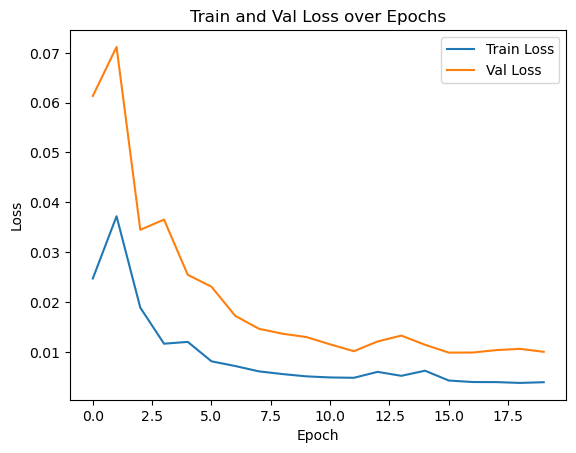

In [277]:
# Plot train and val losses over epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss over Epochs')
plt.legend()
plt.show()


## Report MSE For Test Data

In [235]:
# Evaluate model on test data
test_loss = eval(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# Save average of last 3 train/val losses and test loss to dict
losses = {'train_loss': np.mean(train_losses[-3:]), 'val_loss': np.mean(val_losses[-3:]), 'test_loss': test_loss}


Test Loss: 0.0138


## Plot true vs predicted values

#### Save predictions

In [236]:
# Get predictions on train and val data
model.eval()
predictions = []
actuals = []

pred_ts_train = np.array([])
actual_ts_train = np.array([])

for i, (sequences, labels) in enumerate(train_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(sequences)
        
        # concat the predictions and actuals
        pred_ts_train = np.concatenate([pred_ts_train, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_train = np.concatenate([actual_ts_train, labels.cpu().numpy()[:, 0, 0].flatten() ])


pred_ts_val = np.array([])
actual_ts_val = np.array([])

for i, (sequences, labels) in enumerate(val_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(sequences)

        # concat the predictions and actuals
        pred_ts_val = np.concatenate([pred_ts_val, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_val = np.concatenate([actual_ts_val, labels.cpu().numpy()[:, 0, 0].flatten() ])


# Get predictions on test data
model.eval()

pred_ts = np.array([])
actual_ts = np.array([])

for i, (sequences, labels) in enumerate(test_loader):  
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(sequences)
        
        # concat the predictions and actuals
        pred_ts = np.concatenate([pred_ts, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts = np.concatenate([actual_ts, labels.cpu().numpy()[:, 0, 0].flatten() ])

#### Plot predictions

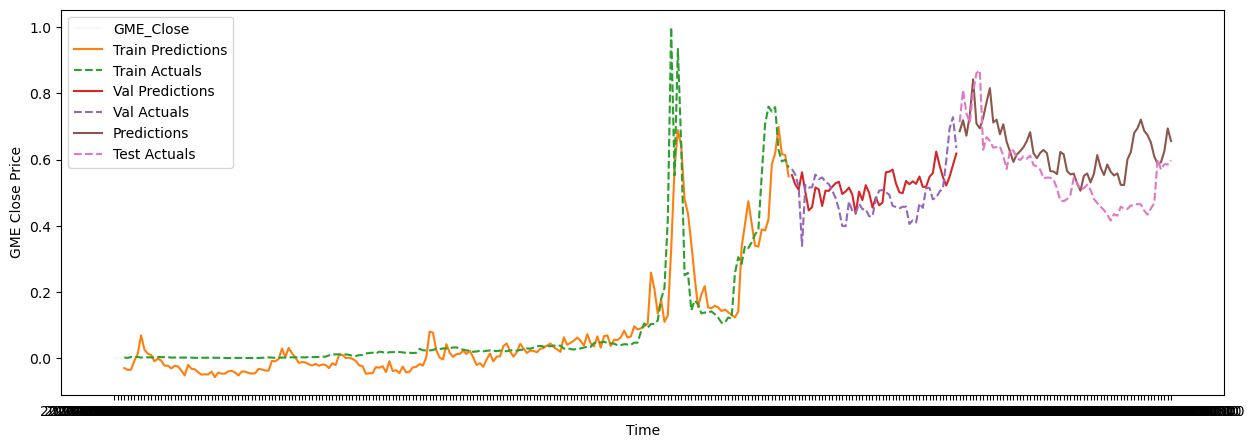

In [237]:
# plot the predictions and actuals

# Big fig size
plt.figure(figsize=(15, 5))

# get dates for train predictions
n_train_prediction = len(pred_ts_train)
dates_train = data_transformed['Date'][seq_length:n_train_prediction+seq_length]

# Get dates for val predictions
n_val_prediction = len(pred_ts_val)
dates_val = data_transformed['Date'][seq_length + n_train_prediction: n_train_prediction + n_val_prediction + seq_length]

# Get dates for the test predictions
n_prediction = len(pred_ts)
dates = data_transformed['Date'][-n_prediction:]



# Plot the GME_Close from the original data after transformation
plt.plot(data_transformed['Date'], data_transformed['GME_Close'] , label='GME_Close', alpha = .05)

# plot train and val predictions
plt.plot(dates_train, pred_ts_train, label='Train Predictions')
plt.plot(dates_train, actual_ts_train, label='Train Actuals', linestyle='dashed')

plt.plot(dates_val, pred_ts_val, label='Val Predictions')
plt.plot(dates_val, actual_ts_val, label='Val Actuals', linestyle='dashed')


plt.plot(dates, pred_ts, label='Predictions')
plt.plot(dates, actual_ts, label='Test Actuals', linestyle='dashed')


plt.xlabel('Time')
plt.ylabel('GME Close Price')

plt.legend()
plt.show()


## Analysis of results:


---
# Sentiment Analysis of Reddit Data


In [238]:
from textblob import TextBlob

In [239]:
# Read in reddit data
reddit_data = pd.read_csv('data/rGME_dataset_features.csv')

# Show all columns
pd.set_option('display.max_columns', None)

print(f"Shape of reddit data: {reddit_data.shape}")
reddit_data.head()

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_23891/2277308162.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_data = pd.read_csv('data/rGME_dataset_features.csv')


Shape of reddit data: (1033236, 74)


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,neg,neu,pos,spacy_title,clean_text,char_count,word_count,word_count_cln,stopword_count,pos_tags,dep_tags,_NOUN,_VERB,_ADP,_ADJ,_DET,_PROPN,_INTJ,_PUNCT,_NUM,_PRON,_ADV,_PART,_amod,_ROOT,_punct,_advmod,_auxpass,_nsubjpass,_ccomp,_acomp,_neg,_nsubj,_aux,_agent,_det,_pobj,_prep,_csubj,_nummod,_attr,_acl,_relcl,_dobj,_pcomp,_xcomp,_cc,_conj,_mark,_prt,_compound,_dep,_advcl,_parataxis,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,0.000,0.189,0.811,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,need GME 🚀 🚀 🚀 🚀 🚀 🚀,37,13,8,5,"{'VERB': 6, 'ADP': 1, 'PROPN': 6}","{'nsubj': 1, 'ROOT': 1, 'aux': 1, 'xcomp': 1, ...",0,6,1,0,0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,0.000,0.079,0.921,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,short squeeze incoming 🚀 🚀 🚀 🚀 🚀 🚀 🚀,30,10,10,0,"{'VERB': 6, 'NOUN': 4}","{'amod': 2, 'ROOT': 1, 'dobj': 4, 'appos': 3}",4,6,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,0.000,0.744,0.256,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,convinced 💰 GME EXTREME PUMP COMING,54,13,6,5,"{'VERB': 5, 'ADP': 3, 'PROPN': 5}","{'nsubj': 2, 'ROOT': 1, 'dobj': 1, 'prep': 2, ...",0,5,3,0,0,5,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,2,0,0,0,2,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,0.115,0.885,0.000,You already know what we must do brothers and ...,know brother sister submit complaint,95,21,5,13,"{'VERB': 17, 'NOUN': 4}","{'nsubj': 3, 'advmod': 1, 'ROOT': 3, 'dobj': 4...",4,17,0,0,0,0,0,0,0,0,0,0,0,3,3,1,0,0,1,0,0,3,2,0,1,0,0,0,0,0,0,0,4,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,0.000,1.000,0.000,ICR conference (11th Jan),ICR conference 11th Jan,25,6,4,0,"{'NOUN': 5, 'PROPN': 1}","{'compound': 1, 'ROOT': 1, 'punct': 2, 'amod':...",5,0,0,0,0,1,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


### How many posts per day?

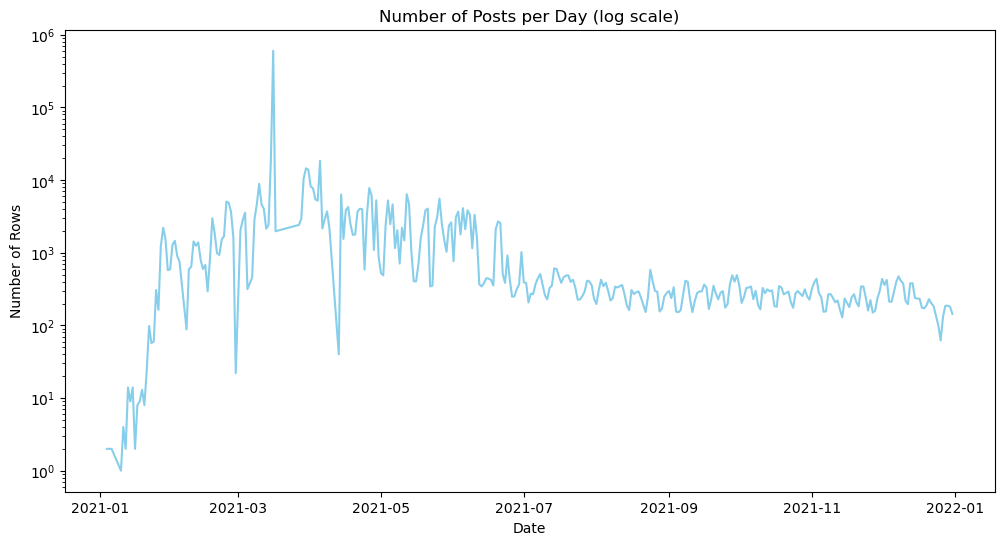

In [240]:
# Convert the 'date' column to datetime
reddit_data['date'] = pd.to_datetime(reddit_data['date'])

# Group by date and count the number of rows
daily_counts = reddit_data.groupby(reddit_data['date'].dt.date).size()

# Plot the number of rows per day
plt.figure(figsize=(12, 6))
daily_counts.plot( color='skyblue')
plt.title('Number of Posts per Day (log scale)')
plt.xlabel('Date')
plt.yscale('log')
plt.ylabel('Number of Rows')
plt.show()


### Use textblob to get sentiment of each post, weight by the number of comments

In [241]:
# Keep relevant columns
reddit_data = reddit_data[['date', 'title', 'num_comments']]

## Use text blob to get sentiment of each post
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'title' column and create a new column 'sentiment'
reddit_data['sentiment'] = reddit_data['title'].apply(get_sentiment)

# Calculate weighted sentiment scores using 'num_comments'
reddit_data['weighted_sentiment'] = reddit_data['sentiment'] * reddit_data['num_comments']

# Aggregate sentiment scores for each day
daily_sentiment = reddit_data.groupby(
                                    reddit_data['date'].dt.date)['weighted_sentiment'].sum() / reddit_data.groupby(
                                            reddit_data['date'].dt.date)['num_comments'].sum()

# Calculate the number of comments per day (log)
daily_comments = np.log(reddit_data.groupby(reddit_data['date'].dt.date)['num_comments'].sum())

# Merge together by date
daily_reddit = pd.concat([daily_sentiment, daily_comments], axis=1)

# Rename columns
daily_reddit.columns = ['sentiment', 'log_comments']

/Users/coltonlapp/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


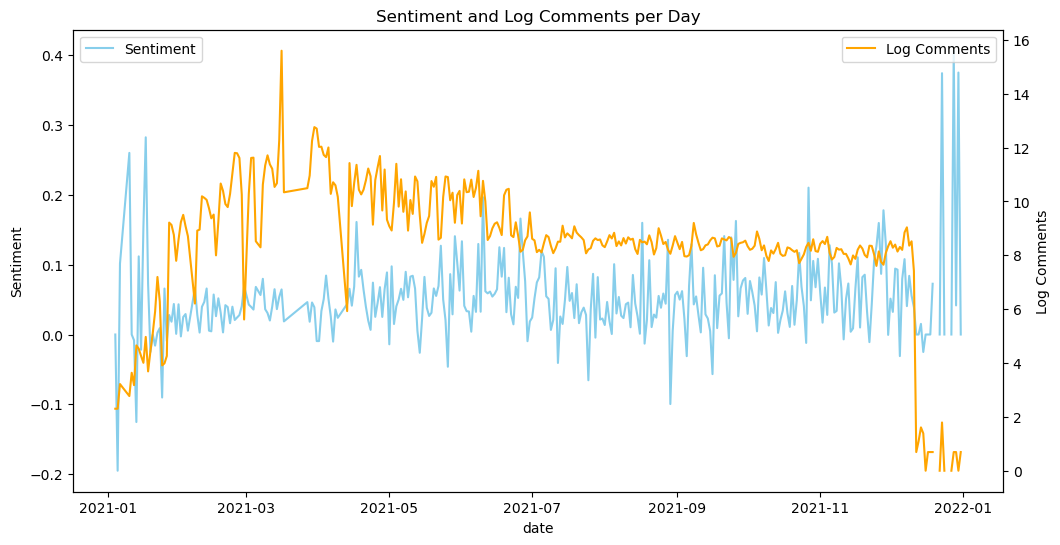

In [242]:
# line plot of sentiment and log comments per day, two axis
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
daily_reddit['sentiment'].plot(ax=ax1, color='skyblue', label='Sentiment')
daily_reddit['log_comments'].plot(ax=ax2, color='orange', label='Log Comments')
ax1.set_ylabel('Sentiment')
ax2.set_ylabel('Log Comments')
plt.title('Sentiment and Log Comments per Day')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()



In [243]:

data_transformed['Date'] = pd.to_datetime(data_transformed['Date'])
data_transformed = data_transformed.set_index('Date')

In [244]:
# merge daily_reddit with data_transformed

# Merge data_transformed with daily_reddit
data_merged = data_transformed.merge(daily_reddit, left_index=True, right_index=True, how='left')

# Fill missing values with 0
data_merged = data_merged.fillna(0)

# Scale sentiment and log_comments columns
scaler_sentiment = MinMaxScaler()
scaler_comments = MinMaxScaler()

data_merged['sentiment'] = scaler_sentiment.fit_transform(data_merged['sentiment'].values.reshape(-1,1))
data_merged['log_comments'] = scaler_comments.fit_transform(data_merged['log_comments'].values.reshape(-1,1))




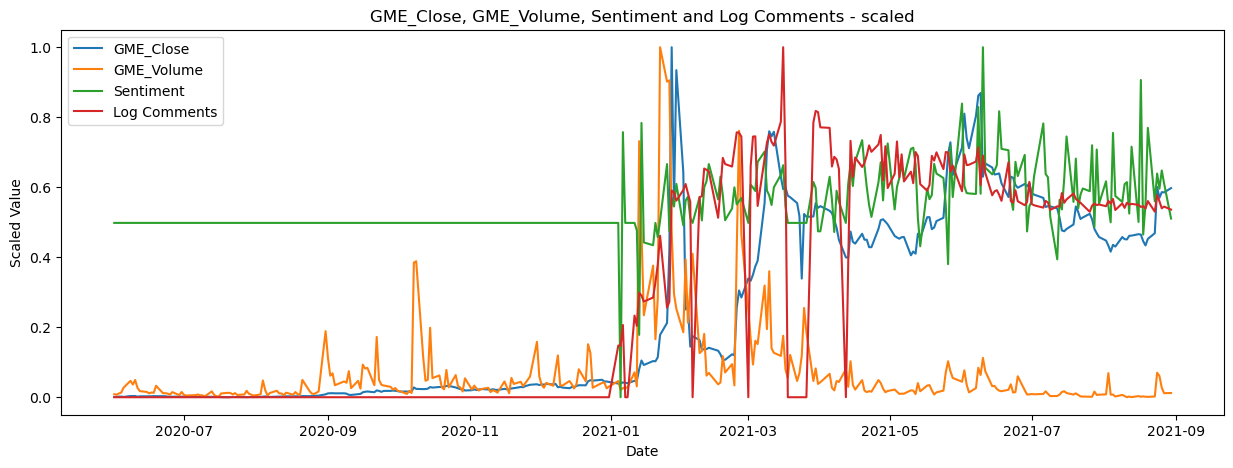

In [245]:
# Plot GME_Close, GME_Volume, Sentiment and Log Comments
plt.figure(figsize=(15, 5))
plt.plot(data_merged.index, data_merged['GME_Close'], label='GME_Close')
plt.plot(data_merged.index, data_merged['GME_Volume'], label='GME_Volume')
plt.plot(data_merged.index, data_merged['sentiment'], label='Sentiment')
plt.plot(data_merged.index, data_merged['log_comments'], label='Log Comments')
plt.title('GME_Close, GME_Volume, Sentiment and Log Comments - scaled')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

In [246]:
# Calculate correlation between GME_Close and sentiment
correlation = data_merged['GME_Close'].corr(data_merged['sentiment'])
print(f"Correlation between GME_Close and sentiment: {correlation:.4f}")


Correlation between GME_Close and sentiment: 0.5549


In [247]:
# Calculate correlation between GME_Close and log_comments
correlation = data_merged['GME_Close'].corr(data_merged['log_comments'])
print(f"Correlation between GME_Close and log_comments: {correlation:.4f}")


Correlation between GME_Close and log_comments: 0.8367


In [248]:
# Retrain LSTM with sentiment and log_comments

data_merged_vals = data_merged.values

# Create sequences
sequences_new = create_sequences(data_merged_vals, seq_length)

# Convert to PyTorch tensors
inputs = torch.Tensor([seq for seq, _ in sequences_new])
labels = torch.Tensor([label for _, label in sequences_new]).unsqueeze(1)  # Unsqueeze to add a singleton dimension

print(f"Shape of inputs: {inputs.shape}")
print(f"Shape of labels: {labels.shape}")


Shape of inputs: torch.Size([313, 3, 23])
Shape of labels: torch.Size([313, 1, 1])


In [249]:
# Create dataset for each set 
train_dataset = TensorDataset(inputs[train_indices], labels[train_indices])
val_dataset = TensorDataset(inputs[val_indices], labels[val_indices])
test_dataset = TensorDataset(inputs[test_indices], labels[test_indices])
entire_dataset = TensorDataset(inputs, labels)

# Create DataLoader for each set, setting pin=True and num_workers = 2
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
entire_loader = DataLoader(entire_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)


Device:  cpu
Epoch 1/20


Train:   0%|          | 0/50 [00:00<?, ?it/s]/Users/coltonlapp/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Train:  96%|█████████▌| 48/50 [00:01<00:00, 48.88it/s, loss=0.0227]/Users/coltonlapp/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Val:  85%|████████▍ | 11/13 [00:00<00:01,  1.12it/s, loss=0.0534]  /Users/coltonlapp/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:5

	Train Loss 0.0247	 Learning Rate 0.0010000
	Val Loss 0.0613


Epoch 6/20


	Train Loss 0.0081	 Learning Rate 0.0010000
	Val Loss 0.0231


Epoch 11/20


	Train Loss 0.0049	 Learning Rate 0.0010000
	Val Loss 0.0115


Epoch 16/20


	Train Loss 0.0042	 Learning Rate 0.0010000
	Val Loss 0.0099


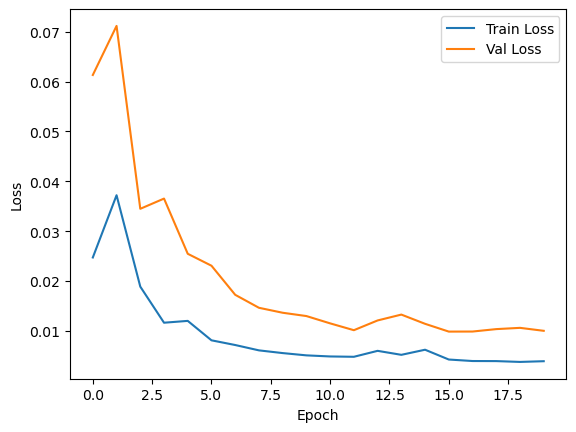

In [250]:
# New LSTM model

# Model parameters
input_size = data_merged_vals.shape[1]  # Number of features
hidden_size = 100
num_layers = 1
output_size = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

# Initialize the model
model_new = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=0.001)


w_and_b = False

train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):

    if epoch  % 5 == 0:
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])
    train_loss  = train(model_new, train_loader, optimizer, criterion, device)
    val_loss = eval(model_new, val_loader, criterion, device)

    if epoch  % 5 == 0:
        print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
        print("\tVal Loss {:.04f}".format(val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)


# Plot train and val losses over epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [251]:
# Evaluate model on test data
test_loss = eval(model_new, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# Save average of last 3 train/val losses and test loss to dict
losses_new = {'train_loss': np.mean(train_losses[-3:]), 'val_loss': np.mean(val_losses[-3:]), 'test_loss': test_loss}

Test Loss: 0.0089


In [252]:
# # Get predictions on train and val data
model_new.eval()
predictions = []
actuals = []

pred_ts_train = np.array([])
actual_ts_train = np.array([])

for i, (sequences, labels) in enumerate(train_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)
        
        # concat the predictions and actuals
        pred_ts_train = np.concatenate([pred_ts_train, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_train = np.concatenate([actual_ts_train, labels.cpu().numpy()[:, 0, 0].flatten() ])


pred_ts_val = np.array([])
actual_ts_val = np.array([])

for i, (sequences, labels) in enumerate(val_loader):
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)

        # concat the predictions and actuals
        pred_ts_val = np.concatenate([pred_ts_val, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts_val = np.concatenate([actual_ts_val, labels.cpu().numpy()[:, 0, 0].flatten() ])


# Get predictions on test data
pred_ts = np.array([])
actual_ts = np.array([])

for i, (sequences, labels) in enumerate(test_loader):  
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)
        
        # concat the predictions and actuals
        pred_ts = np.concatenate([pred_ts, outputs.cpu().numpy()[:, 0, 0].flatten() ])
        actual_ts = np.concatenate([actual_ts, labels.cpu().numpy()[:, 0, 0].flatten() ])

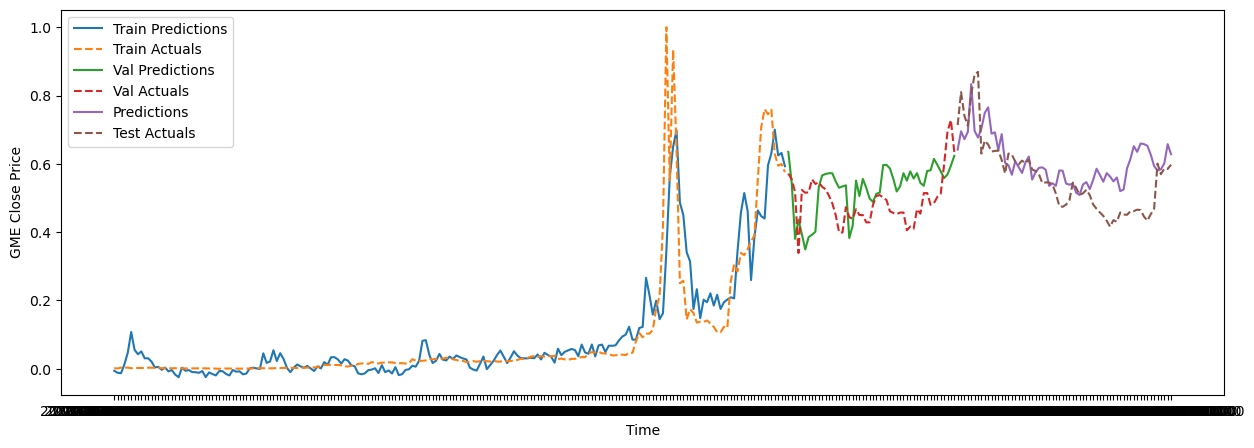

In [253]:
# plot the predictions and actuals

# Big fig size
plt.figure(figsize=(15, 5))

# plot train and val predictions
plt.plot(dates_train, pred_ts_train, label='Train Predictions')
plt.plot(dates_train, actual_ts_train, label='Train Actuals', linestyle='dashed')

plt.plot(dates_val, pred_ts_val, label='Val Predictions')
plt.plot(dates_val, actual_ts_val, label='Val Actuals', linestyle='dashed')


plt.plot(dates, pred_ts, label='Predictions')
plt.plot(dates, actual_ts, label='Test Actuals', linestyle='dashed')


plt.xlabel('Time')
plt.ylabel('GME Close Price')

plt.legend()
plt.show()


### Summary:
Train/Val/Test losses with/without sentiment data



In [254]:
# Compare train/val/test losses for the two models
print("Old Model Losses without sentiment data:")
for k, v in losses.items():
    print(f"{k}: {v:.4f}")

print("\nNew Model Losses WITH sentiment data:")
for k, v in losses_new.items():
    print(f"{k}: {v:.4f}")



Old Model Losses without sentiment data:
train_loss: 0.0047
val_loss: 0.0067
test_loss: 0.0138

New Model Losses WITH sentiment data:
train_loss: 0.0039
val_loss: 0.0103
test_loss: 0.0089


# Sensitivity to Sentiment Analysis

### Add spike of good sentiment/comments to test data and see how trajectory changes

In [255]:
data_modified = data_merged.copy()

# Change values for sentiment and log_comments from 6/1/2021 to 6/15/2021
data_modified.loc['2021-06-01':'2021-06-15', 'sentiment'] = 1
data_modified.loc['2021-06-01':'2021-06-15', 'log_comments'] = data_modified['log_comments'].max()


### Graph test data with sentiment spike at beggining

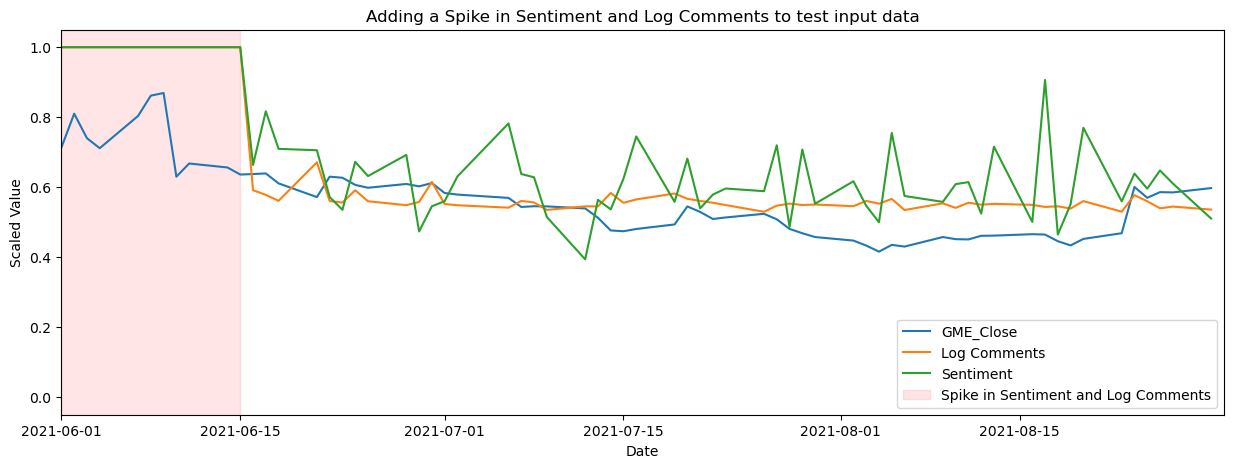

In [256]:

# Graph gme_close, log_comments and sentiment
plt.figure(figsize=(15, 5))
plt.plot(data_modified.index, data_modified['GME_Close'], label='GME_Close')
plt.plot(data_modified.index, data_modified['log_comments'], label='Log Comments')
plt.plot(data_modified.index, data_modified['sentiment'], label='Sentiment')
plt.title('Adding a Spike in Sentiment and Log Comments to test input data')

# x limit from 6/1 to 8/31
plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-08-31'))
# add translucent red box to show where the spike is
plt.axvspan(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-06-15'), color='red', alpha=0.1, label='Spike in Sentiment and Log Comments')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()


### Create new data loader for modified test data

In [257]:
data_modified_vals = data_modified.values

# Create sequences
sequences_new = create_sequences(data_modified_vals, seq_length)

# Convert to PyTorch tensors
inputs_mod = torch.Tensor([seq for seq, _ in sequences_new])
labels_mod = torch.Tensor([label for _, label in sequences_new]).unsqueeze(1)  # Unsqueeze to add a singleton dimension

# Create new test dataset
test_dataset_modified = TensorDataset(inputs_mod[test_indices], labels_mod[test_indices])

# Create DataLoader for each set, setting pin=True and num_workers = 2
batch_size = 4
test_loader_modified = DataLoader(test_dataset_modified, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)



### Feed modified data into LSTM model 

In [258]:
model_new.eval()

# Get predictions on test data
pred_ts_mod = np.array([])

for i, (sequences, labels) in enumerate(test_loader_modified):  
    sequences = sequences.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_new(sequences)
        
        # concat the predictions and actuals
        pred_ts_mod = np.concatenate([pred_ts_mod, outputs.cpu().numpy()[:, 0, 0].flatten() ])



### Plot modified test predictions with/without sentiment spike

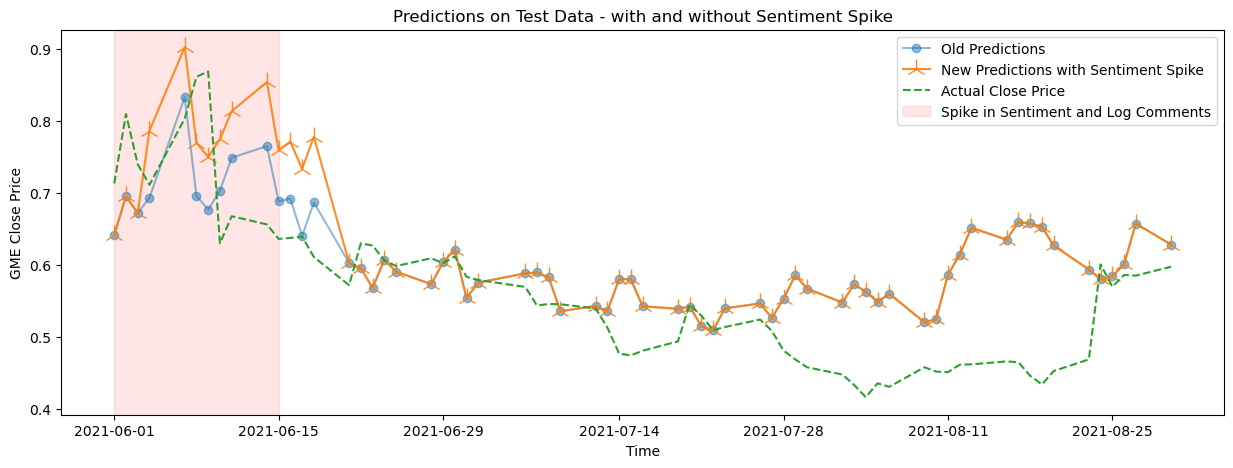

In [278]:
# Get dates for the test predictions
n_prediction_mod = len(pred_ts_mod)
n_prediction = len(pred_ts)

# Turn index into column called "Dates" for data_modified
dates_mod = data_modified.reset_index()['Date'][-n_prediction_mod:]
dates = data_transformed.reset_index()['Date'][-n_prediction:]

# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(dates, pred_ts, label='Old Predictions', alpha = .5, marker='o')
plt.plot( dates_mod, pred_ts_mod, label='New Predictions with Sentiment Spike', marker = '2', alpha = .9, markersize = 15)
plt.plot( dates, actual_ts, label='Actual Close Price', linestyle='dashed')
plt.axvspan(pd.Timestamp('2021-06-01'), pd.Timestamp('2021-06-15'), color='red', alpha=0.1, label='Spike in Sentiment and Log Comments')

# Show x labels only every 10 days
plt.xticks(dates[::10])

plt.xlabel('Time')
plt.ylabel('GME Close Price')
plt.title('Predictions on Test Data - with and without Sentiment Spike')
plt.legend()
plt.show()